In [23]:
import librosa
import glob
import numpy as np
import seaborn as sns
import pandas as pd
from os import path
import matplotlib.pyplot as plt

from time import time

from IPython.display import Audio
from librosa.display import specshow
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

In [24]:
def get_filenames():
    if not path.exists("speechcommands"):
        !wget http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
        !mkdir speechcommands
        !tar -xf speech_commands_v0.01.tar.gz -C speechcommands
    
    numbers_filenames = []

    to_number =	{
      "zero": 0,
      "one": 1,
      "two": 2,
      "three": 3,
      "four": 4,
      "five": 5,
      "six": 6,
      "seven": 7,
      "eight": 8,
      "nine": 9
    }

    for i in to_number:
        path = 'speechcommands/' + i + '/*.wav'
        numbers_filenames.append(glob.glob(path))

    test_filenames = ['speechcommands/' + e for e in open('speechcommands/testing_list.txt','r').read().splitlines() if e[:e.find('/')] in to_number]
    valid_filenames = ['speechcommands/' + e for e in open('speechcommands/validation_list.txt','r').read().splitlines() if e[:e.find('/')] in to_number]
    train_filenames = [e for n in range(10) for e in numbers_filenames[n] if (e not in test_filenames) and (e not in valid_filenames)]

    print('train_count:' , len(train_filenames))
    print('test_count:' , len(test_filenames))
    print('valid_count:' , len(valid_filenames))
    
    return 	{
      "train_features.csv": train_filenames,
      "test_features.csv": test_filenames,
      "valid_features.csv": valid_filenames
    }
    

In [25]:
def count_elapsed_time(f):
    """
    Decorator.
    Execute the function and calculate the elapsed time.
    Print the result to the standard output.
    """
    def wrapper(*args, **kwargs):
        # Start counting.
        start_time = time()
        # Take the original function's return value.
        ret = f(*args, **kwargs)
        # Calculate the elapsed time.
        elapsed_time = time() - start_time
        print("Elapsed time: %0.10f seconds." % elapsed_time)
        return ret

    return wrapper

In [56]:
def aplicar_ruido(audio, ruido):
    if ruido==1:
        return np.random.normal(size=audio.shape) + audio
    else:
        ruidoaudio, sr = librosa.core.load('speechcommands/_background_noise_/doing_the_dishes.wav', sr=None)
        ruidoaudio = ruidoaudio[5000:5000+len(audio)]
        return 0.5*ruidoaudio + audio
    

In [57]:
def calculate_features(filename, n_mfcc=12, delta=True, deltadelta=True, energy=True, summary_fn = [np.mean, np.std], summary_names=['mean', 'std'], ruido=0):  
  #Abro el archivo:
  x, sr = librosa.core.load(filename,sr=None)
  
  if (ruido > 0):
        x = aplicar_ruido(x, ruido)

  #Calculo MFCCs
  features = librosa.feature.mfcc(x,sr=sr,n_mfcc=n_mfcc)

  #Calculo energia:
  if energy:
    energy = librosa.feature.rmse(x)
    features = np.concatenate([features,energy])

  #Aplico media y desvio estandar por defecto
  summary_features = np.concatenate([fn(features,axis=1) for fn in summary_fn])
    
  #Lo mismo con los delta
  if delta:
    deltafeatures = np.diff(features)
    summary_features = np.concatenate([summary_features,np.concatenate([fn(deltafeatures,axis=1) for fn in summary_fn])])

  #Y con los delta de segundo orden
  if deltadelta:
    deltadeltafeatures = np.diff(features,n=2)
    summary_features = np.concatenate([summary_features,np.concatenate([fn(deltadeltafeatures,axis=1) for fn in summary_fn])]) 
  
  summary_features = np.append(summary_features, [to_number[filename.split('/')[1]], filename])

  return summary_features

In [58]:
def name_features(filename = '', n_mfcc=12, delta=True, deltadelta=True, energy=True, summary_fn = [np.mean, np.std], summary_names=['mean', 'std']):
    feat_names = ['mfcc_{}'.format(i) for i in range(n_mfcc)]
    if energy: feat_names = feat_names + ['energy']
    feat_names = ['{}_{}'.format(name_i,summ_i) for summ_i in summary_names for name_i in feat_names]
    if delta: d_names = ['d{}'.format(name) for name in feat_names]
    if deltadelta: dd_names = ['dd{}'.format(name) for name in feat_names]

    feat_names = feat_names + d_names + dd_names + ['digit', 'file']

    return feat_names

In [59]:
@count_elapsed_time
def calculate_features_if_needed(result_filename, ruido=0):
    result_path = "features/"+result_filename
    result = []
    if not path.exists(result_path):
        print("Getting filenames")
        filenames_complete = get_filenames()
        filenames = filenames_complete[result_filename]        
        
        print("Calculating features for ", len(filenames), " rows -> ", result_path)
        features_names = name_features()
        features_data = [calculate_features(x, ruido) for x in filenames]
        pd.DataFrame(data = features_data, columns = features_names).to_csv(result_path)
    
    else:
        print("Loading saved features <- ", result_path)
        result = pd.read_csv(result_path)
    
    return result

##  Obtenemos features  y eliminamos las columnas innecesarias para la predicción

In [29]:
import os.path
from os import path

if not path.exists("features/test_features.csv"):
    !wget https://raw.githubusercontent.com/dhruszecki/cdatos-AA-TP2/master/features/test_features.csv -P features
    
if not path.exists("features/train_features.csv"):        
    !wget https://raw.githubusercontent.com/dhruszecki/cdatos-AA-TP2/master/features/train_features.csv -P features
        
if not path.exists("features/valid_features.csv"):        
    !wget https://raw.githubusercontent.com/dhruszecki/cdatos-AA-TP2/master/features/valid_features.csv -P features


In [30]:
%%time
# Variables a excluir de la predicción
var_exclude = ['file', 'Unnamed: 0']

test_features = pd.DataFrame(calculate_features_if_needed("test_features.csv"))
test_features.drop(var_exclude, axis=1, inplace=True)
test_features.head(10)
pd.crosstab(index=test_features["digit"], columns="count", normalize=True)

Loading saved features <-  features/test_features.csv
Elapsed time: 0.0479600430 seconds.
CPU times: user 51.9 ms, sys: 8.01 ms, total: 59.9 ms
Wall time: 57.6 ms


col_0,count
digit,
0,0.097962
1,0.097179
2,0.103448
3,0.104624
4,0.099138
5,0.106191
6,0.095611
7,0.093652
8,0.100705


In [31]:
%%time
validation_features = pd.DataFrame(calculate_features_if_needed("valid_features.csv"))
validation_features.head(10)

validation_features.drop(var_exclude, axis=1, inplace=True)
validation_features.head(10)
pd.crosstab(index=validation_features["digit"], columns="count", normalize=True)

Loading saved features <-  features/valid_features.csv
Elapsed time: 0.0462124348 seconds.
CPU times: user 49.3 ms, sys: 8.01 ms, total: 57.3 ms
Wall time: 54.8 ms


col_0,count
digit,
0,0.104250
1,0.092221
2,0.094627
3,0.099439
4,0.112269
5,0.097033
6,0.105052
7,0.105453
8,0.097434


In [32]:
%%time
train_features = pd.DataFrame(calculate_features_if_needed("train_features.csv"))
train_features.head(10)
train_features.drop(var_exclude, axis=1, inplace=True)
train_features.head(10)
pd.crosstab(index=train_features["digit"], columns="count", normalize=True)

Loading saved features <-  features/train_features.csv
Elapsed time: 0.2932553291 seconds.
CPU times: user 294 ms, sys: 16 ms, total: 310 ms
Wall time: 306 ms


col_0,count
digit,
0,0.100215
1,0.101611
2,0.100591
3,0.098872
4,0.098765
5,0.099033
6,0.100054
7,0.100698
8,0.099463


In [ ]:
develop_features = validation_features.append(train_features, ignore_index=True)

# Modelos

## Naive Bayes

In [33]:
%%time

naive_bayes_1 = GaussianNB()
naive_bayes_1.fit(train_features.drop('digit',axis=1).values, train_features.digit.values)
predict_nb1 = naive_bayes_1.predict(validation_features.drop('digit',axis=1).values)

print("Accuracy training : {:.3f}".format(naive_bayes_1.score(train_features.drop('digit',axis=1).values, 
                                                               train_features.digit.values)))
print("Accuracy Validación: {:.3f}".format(naive_bayes_1.score(validation_features.drop('digit',axis=1).values, 
                                                          validation_features.digit.values)))

print(classification_report(validation_features.digit.values, predict_nb1))

Accuracy training : 0.541
Accuracy Validación: 0.537
              precision    recall  f1-score   support

           0       0.64      0.65      0.64       260
           1       0.36      0.58      0.45       230
           2       0.37      0.48      0.42       236
           3       0.55      0.55      0.55       248
           4       0.72      0.53      0.61       280
           5       0.54      0.53      0.54       242
           6       0.50      0.58      0.54       262
           7       0.58      0.49      0.53       263
           8       0.74      0.56      0.63       243
           9       0.61      0.41      0.49       230

    accuracy                           0.54      2494
   macro avg       0.56      0.54      0.54      2494
weighted avg       0.57      0.54      0.54      2494

CPU times: user 94.4 ms, sys: 4.01 ms, total: 98.4 ms
Wall time: 96.3 ms


###  Matriz de Confusión 

CPU times: user 174 ms, sys: 0 ns, total: 174 ms
Wall time: 175 ms


Text(32.7, 0.5, 'True')

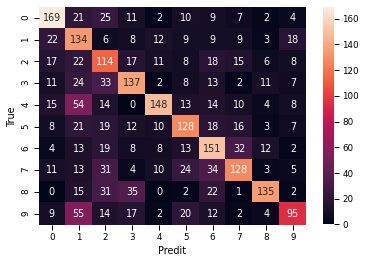

In [51]:
%%time

sns.set_context('paper')
sns.heatmap(confusion_matrix(validation_features.digit.values, predict_nb1), annot=True, fmt='g')
plt.xlabel('Predict')
plt.ylabel('True')

## Random Forest:  búsqueda de hiperparámetros óptimos

In [54]:
%%time

parametros = {'n_estimators':range(100, 250, 15), 'max_depth':range(6, 12, 2), 'bootstrap':[True, False]}

clf = RandomizedSearchCV(RandomForestClassifier(random_state=22), parametros, n_jobs=20, random_state=131313,    
                         scoring='accuracy', n_iter=30, cv =  [(slice(None), slice(None))])

clf.fit(train_features.drop('digit',axis=1).values, train_features.digit.values)
rf = clf.best_estimator_  

print(clf.best_score_, clf.best_params_)
print("Accuracy training : {:.3f}".format(rf.score(train_features.drop('digit',axis=1).values, 
                                                   train_features.digit.values)))
print("Accuracy Validación: {:.3f}".format(rf.score(validation_features.drop('digit',axis=1).values, 
                                                          validation_features.digit.values)))

0.8948979591836734 {'n_estimators': 220, 'max_depth': 10, 'bootstrap': False}
Accuracy training : 0.895
Accuracy Validación: 0.664
CPU times: user 38.6 s, sys: 212 ms, total: 38.8 s
Wall time: 3min 40s


###  Matriz de Confusión 

CPU times: user 245 ms, sys: 0 ns, total: 245 ms
Wall time: 246 ms


Text(32.7, 0.5, 'True')

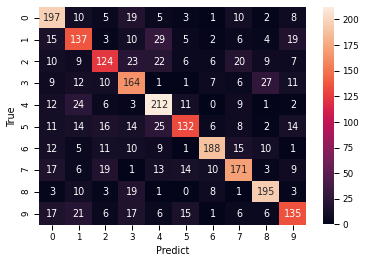

In [55]:
rf_pred = rf.predict(validation_features.drop('digit',axis=1).values)
sns.set_context('paper')
sns.heatmap(confusion_matrix(validation_features.digit.values, rf_pred), annot=True, fmt='g')
plt.xlabel('Predict')
plt.ylabel('True')

## Gradient Boosting

In [44]:
%%time

parameters = {'n_estimators':range(50, 150, 25), 'max_depth':range(5,7), 'learning_rate':np.arange(0,1,0.1)}
clf = RandomizedSearchCV(GradientBoostingClassifier(random_state=22), parameters, n_jobs=30, scoring='accuracy',cv=[(slice(None), slice(None))], n_iter=50, random_state=8)

clf.fit(train_features.drop('digit',axis=1).values, train_features.digit.values)
gb = clf.best_estimator_

print (clf.best_score_, clf.best_params_)
print("Accuracy training : {:.3f}".format(gb.score(train_features.drop('digit',axis=1).values, 
                                                   train_features.digit.values))) 
print("Accuracy validation: {:.3f}".format(gb.score(validation_features.drop('digit',axis=1).values, 
                                                   validation_features.digit.values)))

1.0 {'n_estimators': 125, 'max_depth': 6, 'learning_rate': 0.2}
Accuracy training : 1.000
Accuracy test: 0.742
CPU times: user 17min 49s, sys: 636 ms, total: 17min 50s
Wall time: 2h 52min 12s


###  Matriz de Confusión 

CPU times: user 191 ms, sys: 4 ms, total: 195 ms
Wall time: 216 ms


Text(32.7, 0.5, 'True')

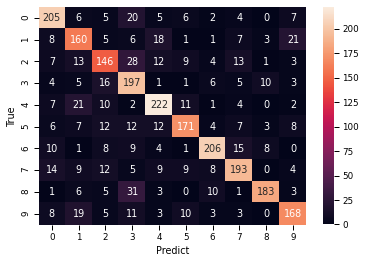

In [50]:
gb_pred = gb.predict(validation_features.drop('digit',axis=1).values)
sns.set_context('paper')
sns.heatmap(confusion_matrix(validation_features.digit.values, gb_pred), annot=True, fmt='g')
plt.xlabel('Predict')
plt.ylabel('True')

In [ ]:
%%time
# Variables a excluir de la predicción
var_exclude = ['file', 'Unnamed: 0']

test_features_g = pd.DataFrame(calculate_features_if_needed("test_features_ruidog.csv", 1))
test_features_g.drop(var_exclude, axis=1, inplace=True)
test_features_g.head(10)
pd.crosstab(index=test_features_g["digit"], columns="count", normalize=True)

In [69]:
%%time

naive_bayes_1 = GaussianNB()
naive_bayes_1.fit(develop_features.drop('digit',axis=1).values, develop_features.digit.values)

predict_nb1_test = naive_bayes_1.predict(test_features.drop('digit',axis=1).values)

#predict_nb1_g = naive_bayes_1.predict(test_features_g.drop('digit',axis=1).values)

# TODO: agregar resto de ruidosos + nuestros


print("Accuracy Develop : {:.3f}".format(naive_bayes_1.score(develop_features.drop('digit',axis=1).values, 
                                                               develop_features.digit.values)))
print("Accuracy Test: {:.3f}".format(naive_bayes_1.score(test_features.drop('digit',axis=1).values, 
                                                          test_features.digit.values)))


#print("Accuracy Test+G: {:.3f}".format(naive_bayes_1.score(test_features_g.drop('digit',axis=1).values, 
#                                                          test_features_g.digit.values)))


print(classification_report(test_features.digit.values, predict_nb1_test))

Accuracy Develop : 0.542
Accuracy Test: 0.531
              precision    recall  f1-score   support

           0       0.55      0.50      0.52       250
           1       0.41      0.49      0.45       248
           2       0.41      0.50      0.45       264
           3       0.54      0.48      0.51       267
           4       0.71      0.57      0.63       253
           5       0.57      0.59      0.58       271
           6       0.48      0.65      0.55       244
           7       0.56      0.46      0.51       239
           8       0.62      0.61      0.61       257
           9       0.59      0.45      0.51       259

    accuracy                           0.53      2552
   macro avg       0.54      0.53      0.53      2552
weighted avg       0.54      0.53      0.53      2552

CPU times: user 145 ms, sys: 4 µs, total: 145 ms
Wall time: 143 ms


In [68]:
%%time

rf.fit(develop_features.drop('digit',axis=1).values, develop_features.digit.values)
#rf_pred_test = rf.predict(test_features.drop('digit',axis=1).values)
#rf_pred_test_g = rf.predict(test_features_g.drop('digit',axis=1).values)

print("Accuracy Develop : {:.3f}".format(rf.score(develop_features.drop('digit',axis=1).values, 
                                                   develop_features.digit.values)))
print("Accuracy Test: {:.3f}".format(rf.score(test_features.drop('digit',axis=1).values, 
                                                          test_features.digit.values)))

Accuracy Develop : 0.879
Accuracy Test: 0.644
CPU times: user 41.8 s, sys: 36 ms, total: 41.8 s
Wall time: 41.9 s


In [71]:
%%time

gb.fit(develop_features.drop('digit',axis=1).values, develop_features.digit.values)

gb_pred_test = gb.predict(test_features.drop('digit',axis=1).values)

print("Accuracy Develop : {:.3f}".format(gb.score(develop_features.drop('digit',axis=1).values, 
                                                   develop_features.digit.values)))
print("Accuracy Test: {:.3f}".format(gb.score(test_features.drop('digit',axis=1).values, 
                                                          test_features.digit.values)))

Accuracy Develop : 1.000
Accuracy Test: 0.728
CPU times: user 18min 38s, sys: 39.5 ms, total: 18min 38s
Wall time: 18min 38s
